In [1]:
import lightning as L
import numpy as np
import torch
import torch.nn.functional as F
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.segment_anything.sam_lora import SAMLoRA
from minerva.transforms.transform import _Transform
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pathlib import Path
import os
import random

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# f3
# train_path = "/workspaces/Minerva-Dev-Container/shared_data/seismic/f3_segmentation/images"
# annotation_path = "/workspaces/Minerva-Dev-Container/shared_data/seismic/f3_segmentation/annotations"

# seam-ai (parihaka)
train_path = "/workspaces/Minerva-Dev-Container/shared_data/seam_ai_datasets/seam_ai/images"
annotation_path = "/workspaces/Minerva-Dev-Container/shared_data/seam_ai_datasets/seam_ai/annotations"

checkpoint_path = "/workspaces/Minerva-Dev-Container/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

In [3]:
# class Padding(_Transform):
#     def __init__(self, target_h_size: int, target_w_size: int):
#         self.target_h_size = target_h_size
#         self.target_w_size = target_w_size

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         h, w = x.shape[:2]
#         pad_h = max(0, self.target_h_size - h)
#         pad_w = max(0, self.target_w_size - w)
#         if len(x.shape) == 2:
#             padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
#             padded = np.expand_dims(padded, axis=2)
#             padded = torch.from_numpy(padded).float()
#         else:
#             padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
#             padded = torch.from_numpy(padded).float()

#         padded = np.transpose(padded, (2, 0, 1))
#         return padded

# class Padding(_Transform):
#     def __init__(self, target_h_size: int, target_w_size: int):
#         self.target_h_size = target_h_size
#         self.target_w_size = target_w_size

#     def __call__(self, x: np.ndarray) -> np.ndarray:
#         h, w = x.shape[:2]
#         pad_h = max(0, self.target_h_size - h)
#         pad_w = max(0, self.target_w_size - w)

#         # Pad the image
#         if len(x.shape) == 2:  # 2D image (grayscale)
#             padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
#             padded = np.expand_dims(padded, axis=2)  # Add channel dimension
#         else:  # 3D image (color)
#             padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")

#         # Convert to tensor and ensure shape is (C, H, W)
#         padded = torch.from_numpy(padded).float()

#         # Transpose to (C, H, W) format
#         padded = padded.permute(2, 0, 1) if len(padded.shape) == 3 else padded.unsqueeze(0)

#         # Ensure output size is (C, target_h_size, target_w_size)
#         padded = F.pad(padded, (0, self.target_w_size - padded.shape[2], 0, self.target_h_size - padded.shape[1]), "reflect")

#         return padded

# transform = Padding(512, 512)

from scipy.ndimage.interpolation import zoom

class RandomGeneratorForImage(_Transform):
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, sample: np.ndarray) -> np.ndarray:
        channels, x, y = sample.shape
        
        # Redimensiona cada canal individualmente para evitar o erro de dimensão
        resized_channels = [
            zoom(sample[c], (self.output_size[0] / x, self.output_size[1] / y), order=3)
            for c in range(channels)
        ]
        
        # Converte a lista de canais redimensionados de volta para um array numpy e, em seguida, para um tensor PyTorch
        image = np.stack(resized_channels, axis=0).astype(np.float32)
        image = torch.from_numpy(image)
        return image

class RandomGeneratorForLabel(_Transform):
    def __init__(self, output_size):
        self.output_size = output_size
        # self.low_res = low_res

    def __call__(self, sample: np.ndarray) -> np.ndarray:
        label = sample

        x, y = label.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        label = torch.from_numpy(label.astype(np.float32))
        return label.long()

transformImage = RandomGeneratorForImage((512, 512))
transformLabel = RandomGeneratorForLabel((512, 512))

/tmp/ipykernel_2826603/3997028444.py:51: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [4]:
import cv2
from patchify import patchify

def rotate_and_flip_patch(patch_img, patch_label):
    rotate = cv2.ROTATE_90_CLOCKWISE
    # Rotaciona -90 graus (equivalente a transpor e depois inverter verticalmente)
    patch_img_rotated = cv2.rotate(patch_img, rotate)
    patch_label_rotated = cv2.rotate(patch_label, rotate)
    # Espelha horizontalmente
    patch_img_flipped = cv2.flip(patch_img_rotated, 1)
    patch_label_flipped = cv2.flip(patch_label_rotated, 1)
    return patch_img_flipped, patch_label_flipped

def resize_image(image, target_shape):
    return cv2.resize(image, target_shape, interpolation=cv2.INTER_LINEAR)

def cria_patchs_sismicas(images, labels, patch_size=(512,512), step=512):
    all_img_patches = []
    all_label_patches = []
    for i, large_image in enumerate(images): # iterando as imagens
        # plt.figure(figsize=(8, 8))
        # plt.imshow(cv2.cvtColor(np.array(large_image), cv2.COLOR_BGR2RGB))  # Convertendo BGR para RGB para visualização correta
        # plt.title("large_image")
        # plt.axis('off')
        # plt.show()
        # Garantir que a imagem está deitada
        # if large_image.shape[0] > large_image.shape[1]:
        #     large_image = cv2.rotate(np.array(large_image), cv2.ROTATE_90_CLOCKWISE)
        #     label = cv2.rotate(np.array(labels[i]), cv2.ROTATE_90_CLOCKWISE)
        
        target_shape = ((large_image.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_image.shape[0] // patch_size[0] + 1) * patch_size[0])
        
        large_image_resized = resize_image(np.array(large_image), target_shape)
        # print("large_image shape:", large_image.shape)
        # print("large_image type:", type(large_image))
        # print("Target shape:", target_shape)
        # print("large_image_resized shape:", large_image_resized.shape)
        # print("large_image_resized type:", type(large_image_resized))
        # print("patch_size shape:", patch_size)
        # print("step shape:", step)

        # # Plotando a imagem redimensionada
        # plt.figure(figsize=(8, 8))
        # plt.imshow(cv2.cvtColor(np.array(large_image), cv2.COLOR_BGR2RGB))  # Convertendo BGR para RGB para visualização correta
        # plt.title("large_image")
        # plt.axis('off')
        # plt.show()

        # Garantir que os rótulos também tenham o tipo correto
        label = np.array(labels[i]).astype(np.uint8)
        
        # plt.figure(figsize=(8, 8))
        # plt.imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))  # Convertendo BGR para RGB para visualização correta
        # plt.title("labels")
        # plt.axis('off')
        # plt.show()
        
        large_label_resized = resize_image(label, target_shape)
        # print("label")
        # print("Original label shape:", label.shape)
        # print("Target shape:", target_shape)
        # print("Resized shape:", large_label_resized.shape)
        # print("patch_size shape:", patch_size)
        # print("step shape:", step)
        
        # Verifica se as dimensões redimensionadas são múltiplos exatos do patch_size
        assert large_image_resized.shape[0] % patch_size[0] == 0, "Altura da imagem não é múltipla do patch_size."
        assert large_image_resized.shape[1] % patch_size[1] == 0, "Largura da imagem não é múltipla do patch_size."
        assert large_label_resized.shape[0] % patch_size[0] == 0, "Altura da label não é múltipla do patch_size."
        assert large_label_resized.shape[1] % patch_size[1] == 0, "Largura da label não é múltipla do patch_size."
        # plt.imshow(large_image)
        # plt.show()
        # plt.imshow(large_image_resized)
        # plt.show()

        patches_img = patchify(large_image_resized, patch_size=patch_size + (3,), step=step)
        # print(len(patches_img), patches_img.shape)
        patches_label = patchify(large_label_resized, patch_size=patch_size, step=step)
        # print(len(patches_label), patches_label.shape)

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, 0]  # Remove a dimensão extra da Imagem
                single_patch_label = patches_label[i, j]  # Remove a dimensão extra da Label
                
                # Converte o patch da imagem para float32
                single_patch_img = np.transpose(single_patch_img, (2, 0, 1)).astype(np.float32)
                # Converte o patch do rótulo para int64 (long)
                single_patch_label = single_patch_label.astype(np.int64)
                
                # single_patch_img, single_patch_label = rotate_and_flip_patch(single_patch_img, single_patch_label) # Aplica a rotação e espelhamento
                # print(single_patch_img.shape, single_patch_label.shape)
                # plt.imshow(single_patch_img)
                # plt.title(f"Patch ({i}, {j})")
                # plt.axis('off')
                # plt.show()
                # plt.imshow(single_patch_label)
                # plt.title(f"Patch ({i}, {j})")
                # plt.axis('off')
                # plt.show()
                # single_patch_img = np.transpose(single_patch_img, (2, 0, 1))
                # single_patch_label = np.transpose(single_patch_label, (2, 0, 1))
                
                all_img_patches.append(single_patch_img)
                all_label_patches.append(single_patch_label)
        # break
    return np.array(all_img_patches), np.array(all_label_patches)

In [ ]:
class F3DataModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        transforms: _Transform = None,
        batch_size: int = 1,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReader(self.train_path / "train")
            train_label_reader = PNGReader(self.annotations_path / "train")
            
            # TODO aplicar patchify, e pra cada (img, label), aplicar o RandomTransform()
            # e só depois jogar no SupervisedReconstructionDataset().
            # Ou então ajeitar o RandomTransform() para enviar diretamente ao SupervisedReconstructionDataset()
            train_imgs, train_labels = cria_patchs_sismicas(train_img_reader, train_label_reader)
            # print(train_imgs.shape)
            # print(train_labels.shape)

            train_dataset = SupervisedReconstructionDataset(
                readers=[train_imgs, train_labels],
                transforms=self.transforms,
            )

            val_img_reader = TiffReader(self.train_path / "val")
            val_label_reader = PNGReader(self.annotations_path / "val")

            # TODO aplicar patchify, e pra cada (img, label), aplicar o RandomTransform()
            # e só depois jogar no SupervisedReconstructionDataset().
            # Ou então ajeitar o RandomTransform() para enviar diretamente ao SupervisedReconstructionDataset()
            val_imgs, val_labels = cria_patchs_sismicas(val_img_reader, val_label_reader)

            val_dataset = SupervisedReconstructionDataset(
                readers=[val_imgs, val_labels],
                transforms=self.transforms,
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReader(self.train_path / "test")
            test_label_reader = PNGReader(self.annotations_path / "test")

            # TODO aplicar patchify, e pra cada (img, label), aplicar o RandomTransform()
            # e só depois jogar no SupervisedReconstructionDataset().
            # Ou então ajeitar o RandomTransform() para enviar diretamente ao SupervisedReconstructionDataset()
            test_imgs, test_labels = cria_patchs_sismicas(test_img_reader, test_label_reader)

            test_dataset = SupervisedReconstructionDataset(
                readers=[test_imgs, test_labels],
                transforms=self.transforms,
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True, 
            worker_init_fn=self.worker_init_fn,
            drop_last=False
        )
    def worker_init_fn(self, worker_id):
        random.seed(18 + worker_id)

data_module = F3DataModule(
    train_path=train_path,
    annotations_path=annotation_path,
    # transforms=transform,
    transforms=[transformImage, transformLabel],
    batch_size=4,
)

In [6]:
# Configura o DataModule para o estágio de treinamento
data_module.setup(stage='fit')

# Obtenha o DataLoader para os dados de treinamento
train_loader = data_module.train_dataloader()

: 

In [8]:
# import gc
# # Define o número de amostras que queremos exibir
# num_amostras = 6
# amostras = []

# # Itera pelos batches para coletar as amostras
# print(len(train_loader))
# for batch in train_loader:
#     image, label = batch
#     print(image.shape, label.shape)
#     image_np = image.permute(0, 2, 3, 1).detach().cpu().numpy()  # Ajusta para HWC (batch, height, width, channels)
#     label_np = label.detach().cpu().numpy()  # Sem permutação, pois já está em formato HW

#     # Normaliza a imagem se necessário
#     if image_np.max() > 1:
#         image_np = image_np / 255.0

#     # Adiciona cada imagem e rótulo ao conjunto de amostras até atingir o número desejado
#     for i in range(image_np.shape[0]):
#         amostras.append((image_np[i], label_np[i]))
#         if len(amostras) >= num_amostras:
#             break
#     if len(amostras) >= num_amostras:
#         break

# # Plota as 6 amostras em uma grade 3x2
# for idx, (img, lbl) in enumerate(amostras):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#     # Plota a imagem
#     axs[0].imshow(img)
#     axs[0].set_title("Imagem")
#     axs[0].axis('off')

#     # Plota o rótulo
#     axs[1].imshow(lbl, cmap='gray')
#     axs[1].set_title("Rótulo")
#     axs[1].axis('off')

#     plt.show()

### instancia o modelo

In [9]:
model = SAMLoRA(
    image_size=512,
    num_classes=5, # considera 6 pois internamente o sam faz +1 pro background
    # pixel_mean=pixel_mean,
    # pixel_std=pixel_std,
    alpha=1,
    rank=4,
    # apply_lora_vision_encoder=apply_lora_vision_encoder,
    # apply_lora_mask_decoder=apply_lora_mask_decoder,
    # frozen_vision_encoder=frozen_vision_encoder,
    # frozen_prompt_encoder=frozen_prompt_encoder,
    # frozen_mask_decoder=frozen_mask_decoder,
    # vit_model=vit_model,
    checkpoint=checkpoint_path,
    # train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    # test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
)

/home/vscode/.local/lib/python3.10/site-packages/minerva/models/nets/image/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torc

In [10]:
from lightning.pytorch.loggers import TensorBoardLogger
# Defina o logger do TensorBoard
logger = TensorBoardLogger("logs", name="sam_model")

trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    logger=logger
)
# trainer.fit(model, data_module)

pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Log directory set to: /workspaces/Minerva-Dev-Container/notebooks/logs/sam_model/version_3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | ce_loss   | CrossEntropyLoss | 0      | train
1 | dice_loss | DiceLoss         | 0      | train
2 | model     | Sam              | 91.8 M | train
-------------------------------------------------------
191 K     Trainable params
91.6 M    Non-trainable params
91.8 M    Total params
367.260   Total estimated model params size (MB)
310       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 339/339 [00:41<00:00,  8.09it/s, v_num=3, train_loss_step=0.144, val_loss_step=0.144, val_pixel_accuracy=0.984, val_mean_class_accuracy=0.976, val_dice_score=0.984, val_mIoU=0.950, val_loss_epoch=0.0989, train_pixel_accuracy=0.984, train_mean_class_accuracy=0.976, train_dice_score=0.984, train_mIoU=0.949, train_loss_epoch=0.067]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 339/339 [00:42<00:00,  7.95it/s, v_num=3, train_loss_step=0.144, val_loss_step=0.144, val_pixel_accuracy=0.984, val_mean_class_accuracy=0.976, val_dice_score=0.984, val_mIoU=0.950, val_loss_epoch=0.0989, train_pixel_accuracy=0.984, train_mean_class_accuracy=0.976, train_dice_score=0.984, train_mIoU=0.949, train_loss_epoch=0.067]
Pipeline info saved at: /workspaces/Minerva-Dev-Container/notebooks/logs/sam_model/version_3/run_2024-11-02-15-43-164bcf6f4ad3864e4e93ae0370dc01484c.yaml


In [11]:
# !tensorboard --logdir logs/

In [ ]:
# trainer.test(model, data_module)
pipeline.run(data=data_module, task="test")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 200/200 [00:10<00:00, 18.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_dice_score      │    0.9221548438072205     │
│      test_loss_epoch      │    0.2616531252861023     │
│         test_mIoU         │    0.7319445610046387     │
│ test_mean_class_accuracy  │    0.8064001202583313     │
│    test_pixel_accuracy    │    0.9221548438072205     │
└───────────────────────────┴───────────────────────────┘

Pipeline info saved at: /workspaces/Minerva-Dev-Container/notebooks/logs/sam_model/version_3/run_2024-11-02-15-43-164bcf6f4ad3864e4e93ae0370dc01484c.yaml


[{'test_pixel_accuracy': 0.9221548438072205,
  'test_mean_class_accuracy': 0.8064001202583313,
  'test_dice_score': 0.9221548438072205,
  'test_mIoU': 0.7319445610046387,
  'test_loss_epoch': 0.2616531252861023}]

In [13]:
# preds = trainer.predict(model, data_module)
preds = pipeline.run(data=data_module, task="predict")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 200/200 [00:11<00:00, 17.92it/s]
Pipeline info saved at: /workspaces/Minerva-Dev-Container/notebooks/logs/sam_model/version_3/run_2024-11-02-15-43-164bcf6f4ad3864e4e93ae0370dc01484c.yaml


In [14]:
image = torch.argmax(preds[108]['masks'], dim=1)

In [15]:
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

TypeError: Invalid shape (4, 512, 512) for image data

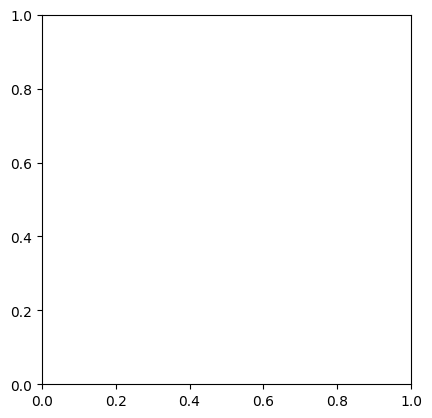

In [16]:
plt.imshow(image.squeeze().numpy(), cmap=label_cmap)
plt.show()